# 6.5 Beyond symmetry
see https://arxiv.org/abs/2305.00066

In [1]:
import numpy as np
from scipy.signal import convolve, convolve2d
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator as rgi
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from timeit import default_timer as tmr
from scipy.ndimage import gaussian_filter1d

In [2]:
from initial_conditions import Domain, Heaviside, LinearRamp, SmoothRamp, Sigmoid, CkRamp
from basis_functions import SVD, Trigonometric, Trigonometric2, TrigonometricOdd, Greedy, LNA, LPF, Sinc

In [3]:
m, n, r = 2500, 2500, 2500
s = 20  # steps

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = plt.cm.plasma
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

fs = 10
fs_lbl = 6
plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = fs
plt.rcParams['axes.titlesize'] = fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['legend.labelspacing'] = 0.0
plt.rcParams['legend.fontsize'] = fs_lbl
plt.rcParams['legend.handlelength'] = 1.0

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')
pth = "../Plots/"

8.030570172000001


In [5]:
def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom')

In [6]:
def plot_f(y):
    xe = np.linspace(-1, 1, 2*m+1)
    xi = (xe[1:]+xe[:-1])/2

    fig, ax = plt.subplots()
    plt.plot(xi, y, "b--")
    plt.plot(xi, y, "b.")
    plt.grid()
    #ax.add_patch(Rectangle((0, -1), 1, 2, fc="grey", ec="k", lw=3, alpha=.2))
    draw_brace(ax, (0, 1), 0.0, "")
    ax.text(.5, 0.2, r'$\Omega$', fontdict={"fontsize": 16, "ha": "center"})
    ax.text(-.4, 0.03, r'inflow', fontdict={"fontsize": 10})
    ax.annotate("", xy=(-0.0, 0.0), xytext=(-.4, 0), arrowprops=dict(arrowstyle="->"))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f(x)$")
    ax.set_ylim([-1, 1])
    #plt.show()
    return fig, ax

## make a random initial condition

In [7]:
def make_random_IC(s=20):
    xe = np.linspace(-1, 1, s+1)
    xm = (xe[1:]+xe[:-1])/2
    steps = np.random.rand(s,)*2-1


    interp  = rgi([xm, ], steps, method="nearest", bounds_error=False, fill_value=None)
    xe = np.linspace(-1, 1, 2*m+1)
    xi = (xe[1:]+xe[:-1])/2
    y = interp(xi)
    
    plot_f(y)
    #plt.plot(xm, steps, "ro")
    plt.show()

    return y

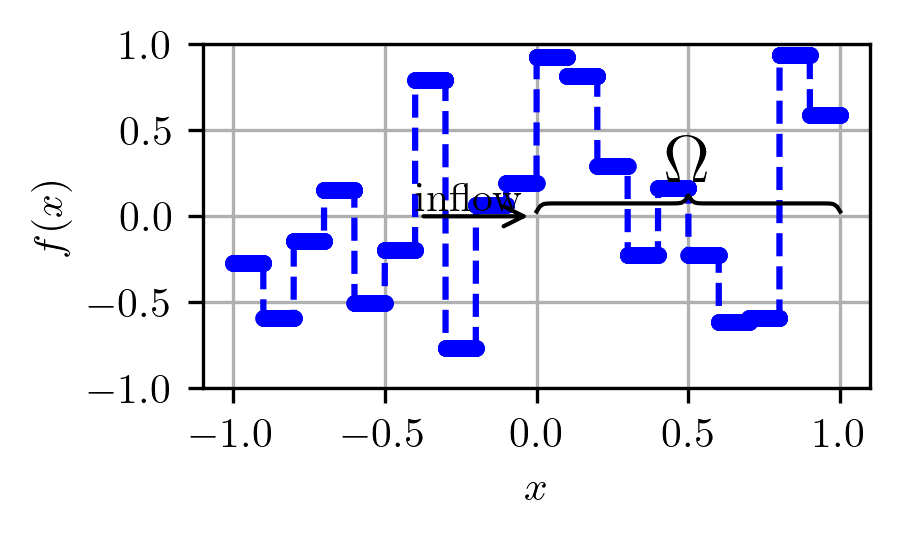

In [8]:
f = make_random_IC(s=s)

## k- fold convolution, SVD and error computation
kernel width: at least max distance between discontinuities to increase degree of smoothness


In [9]:
p = 25

print(f.shape)
d_Ns = {}
delta_Ns = {}
f_convolved = {}

kernel_width = 2*m/s  # 1%
print(m, s, kernel_width)
kernel_width = np.int32(kernel_width)
print(kernel_width)
kernel = np.ones(kernel_width) / kernel_width

xe = np.linspace(-1, 1, 2*m+1)
xi = (xe[1:]+xe[:-1])/2

n_padding = 5*kernel_width
f_convolved[0] = np.zeros((2*m+2*n_padding))
f_convolved[0][n_padding:-n_padding] = f.copy()

for k in range(5):
    t0 = tmr()
    fk = f_convolved[k][n_padding:-n_padding]
    Xk = np.zeros((m, n))
    for j in range(n):
        Xk[:, j] = fk[(m-j):(m-j+m)]

    t1 = tmr()
    print("snapshot matrix made", t1-t0)
    svd_basis = SVD(Xk)
    t2 = tmr()
    print("SVD'ed", t2-t1)
    delta_n, d_n = svd_basis.calc_error()
    t3 = tmr()
    print("error calculated", t3-t2)
    d_Ns[k] = d_n
    delta_Ns[k] = delta_n
    
    #_fk_ = gaussian_filter1d(f_convolved[k], 5, mode="wrap")
    f_convolved[k+1] = convolve(f_convolved[k], kernel, 'same')
    t4 = tmr()
    print("convolved", t4-t3)

(5000,)
2500 20 250.0
250
snapshot matrix made 0.07485649921000004
SVD'ed 12.293866593390703
error calculated 0.0002578515559434891
convolved 0.0005798190832138062
snapshot matrix made 0.07419456355273724
SVD'ed 14.142108831554651
error calculated 0.00029469840228557587
convolved 0.0006093177944421768
snapshot matrix made 0.059820305556058884
SVD'ed 18.684377310797572
error calculated 0.0007287431508302689
convolved 0.0007211416959762573
snapshot matrix made 0.07481264881789684
SVD'ed 20.283386383205652
error calculated 0.00030769966542720795
convolved 0.0008779540657997131
snapshot matrix made 0.0679162759333849
SVD'ed 22.62936749123037
error calculated 0.0007145926356315613
convolved 0.0008293166756629944


## Fig. 6a: Piecewise constant with 20 random steps (dark blue); increasing smoothness Ck(ΩP ) by k + 1-fold convolution, k = 0, ..., 3.
and numerical computation of the k-th derivative to check its smoothness

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


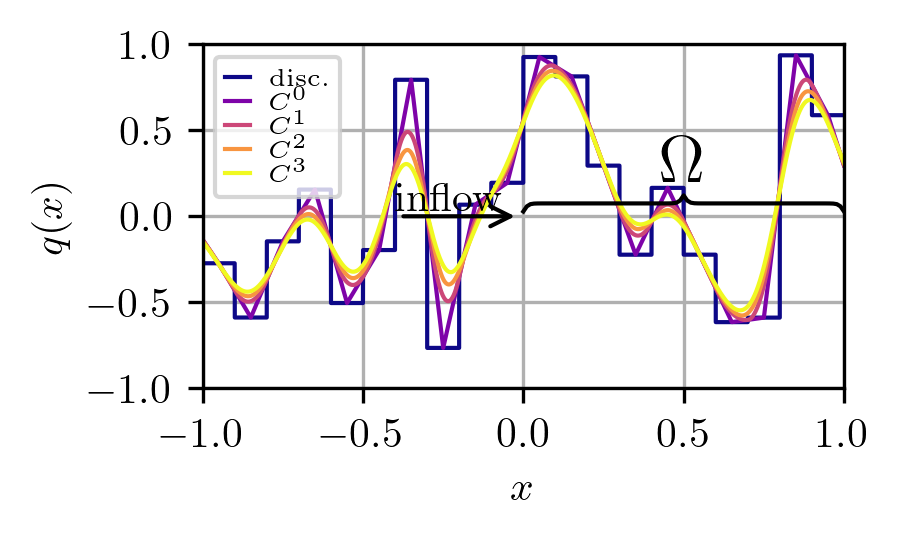

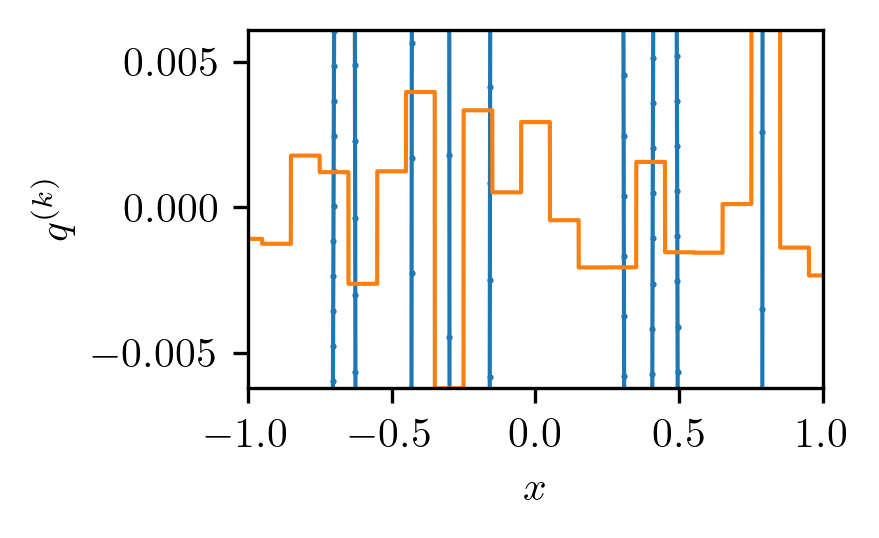

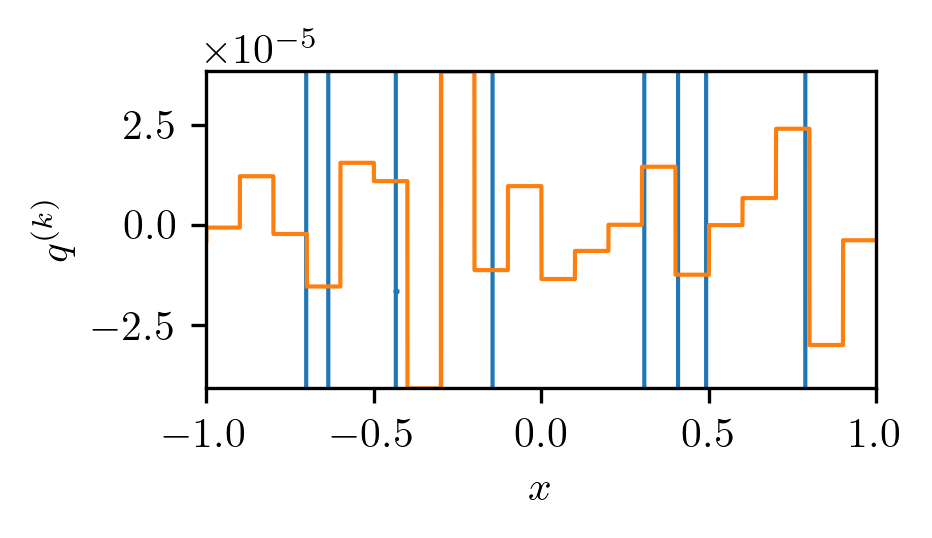

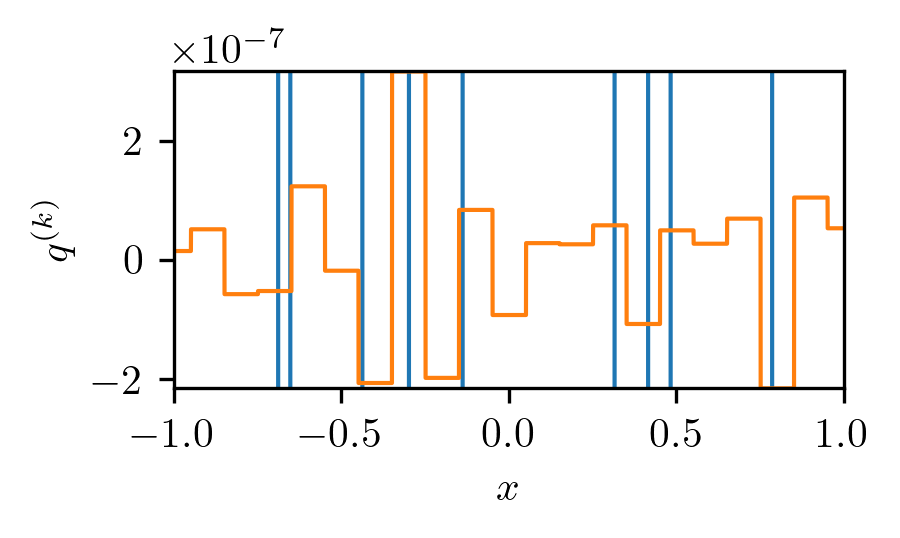

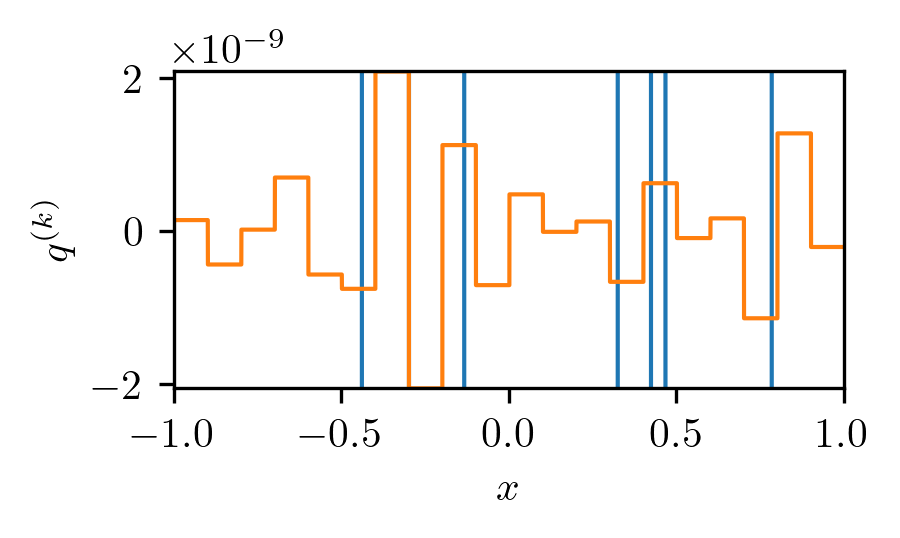

In [10]:
def ddx(y, n=1):
    derivative = y
    for i in range(n):
        derivative = np.diff(derivative, prepend=0)
    return derivative

fig_fk, ax_fk = plt.subplots(tight_layout=True)

for k in range(5):
    if k == 0:
        lbl = "disc."
    else:
        lbl = "$C^{:.0f}$".format(k-1)

    fk = f_convolved[k][n_padding:-n_padding]
    ax_fk.plot(xi, fk, "-", ms=1, lw=1, color=cmap(k/4), label=lbl)
    if k != 0:
        fig, ax_ddx = plt.subplots()
        ax_ddx.plot(xi, fk, ".-", ms=1, lw=1)
        for ki in range(1, k+1):
            derivative_N = ddx(f_convolved[k], ki)[n_padding:-n_padding]
        ax_ddx.plot(xi, derivative_N, "-", ms=1, lw=1)
        ax_ddx.set_xlim([-1, 1])
        ax_ddx.set_ylim([derivative_N.min(), derivative_N.max()])
        ax_ddx.set_xlabel("$x$")
        ax_ddx.set_ylabel("$q^{(k)}$")

ax_fk.grid(which="both")
#ax.add_patch(Rectangle((0, -1), 1, 2, fc="grey", ec="k", lw=3, alpha=.2))
draw_brace(ax_fk, (0, 1), 0.0, "")
ax_fk.text(.5, 0.2, r'$\Omega$', fontdict={"fontsize": 16, "ha": "center"})
ax_fk.text(-.4, 0.03, r'inflow', fontdict={"fontsize": 10})
ax_fk.annotate("", xy=(-0.0, 0.0), xytext=(-.4, 0), arrowprops=dict(arrowstyle="->"))
ax_fk.set_xlabel("$x$")
ax_fk.set_ylabel("$q(x)$")
ax_fk.set_xlim([-1, 1])
ax_fk.set_ylim([-1, 1])
ax_fk.legend()
fig_fk.savefig(pth+"randomIC_1.pdf")

## Fig. 6 (b) N -width decay for discontinuous function and g ∈ Ck(ΩP ), k = 0, ..., 3.

1.6015328868830574
16.94429581999944
212.6618910570356
2978.809561772235
42917.84114858799


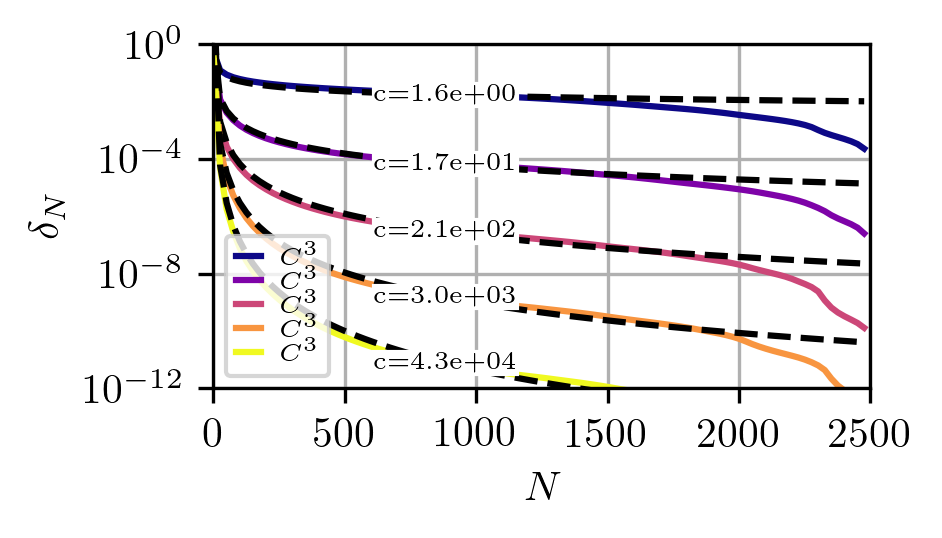

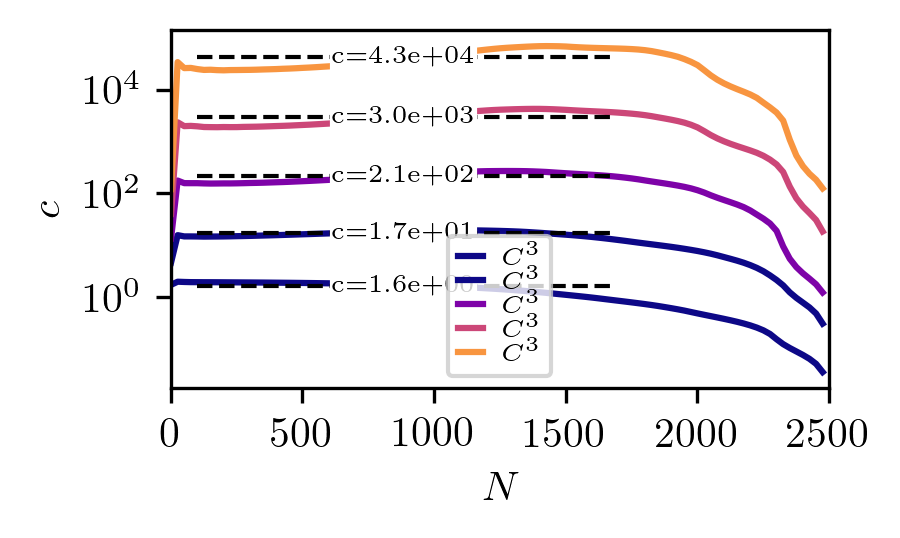

In [11]:
p = 25
    
fig_dN, ax_dN = plt.subplots(tight_layout=True)
fig_d_est, ax_d_est = plt.subplots(tight_layout=True)

for k in range(5):

    d_n = d_Ns[k]
    delta_n = delta_Ns[k]

    N = np.arange(len(delta_n))+1
    ax_dN.plot(N[::p], delta_n[::p], "-", color=cmap(k/4), label=lbl)
    
    k = k-1
    model = 1/np.pi**(k+2) * N**(-(2*k+3)/2)
    C = delta_n/model
    C_estimated = np.mean(C[100: r//3*2])
    print(C_estimated)
    #ax.plot(N, C_estimated*model, "k--", lw=1, ms=0)

    ax_d_est.plot(N[::p], C[::p], "-", color=cmap(k/4), label=lbl)
    ax_d_est.plot([100, r/3*2], [C_estimated, C_estimated], "k--", lw=1)
    ltex = ax_d_est.text(r/3+50, C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))
    ax_dN.plot(N[::p], model[::p]*C_estimated, "k--")
    ltex = ax_dN.text(r//3+50, model[r//3+50]*C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))

ax_dN.set_ylim([1e-12, 1e+0])
ax_dN.set_xlim([0, r]) 
ax_dN.set_yscale('log')
ax_dN.legend()
ax_dN.set_xlabel(r'$N$')
ax_dN.set_ylabel(r'$\delta_N$')
ax_dN.grid(which="both")


plt.tight_layout()

ax_d_est.legend()
ax_d_est.set_yscale('log')
ax_d_est.set_xlim([0, r])
#ax_d_est.set_ylim([0, 10])
ax_d_est.set_xlabel(r'$N$')
ax_d_est.set_ylabel(r'$c$')

fig_dN.savefig(pth+"random_1D_decay.pdf")

plt.show()

In [12]:
delta_Ns[0].shape

(2500,)

In [13]:
N = np.arange(r//3*2)
for i in range(4):
    fig, ax = plt.subplots()
    plt.plot(N, (delta_Ns[i]/delta_Ns[i+1])[N])
    #plt.xlim(0, 750)
    #plt.ylim(0, 25)
    plt.ylabel("dN_{:.0f}/dN_{:.0f}".format(i, i+1))
    plt.show()


RuntimeError: latex was not able to process the following string:
b'dN_0/dN_1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/florianma@ad.ife.no/.cache/matplotlib/tex.cache/6a84da8a7c2c39af015d12ad
d2feba5a.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 6a84da8a7c2c39af015d12add2feba5a.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily dN_
                   0/dN_1}
No pages of output.
Transcript written on 6a84da8a7c2c39af015d12add2feba5a.log.




<Figure size 948.493x586.201 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'dN_1/dN_2'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/florianma@ad.ife.no/.cache/matplotlib/tex.cache/501df894d9fd72771753c043
bfd04885.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 501df894d9fd72771753c043bfd04885.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily dN_
                   1/dN_2}
No pages of output.
Transcript written on 501df894d9fd72771753c043bfd04885.log.




<Figure size 948.493x586.201 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'dN_2/dN_3'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/florianma@ad.ife.no/.cache/matplotlib/tex.cache/4cbfbce6980c70906e1ec2fd
909da0bf.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 4cbfbce6980c70906e1ec2fd909da0bf.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily dN_
                   2/dN_3}
No pages of output.
Transcript written on 4cbfbce6980c70906e1ec2fd909da0bf.log.




<Figure size 948.493x586.201 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'dN_3/dN_4'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/florianma@ad.ife.no/.cache/matplotlib/tex.cache/acb30d500363fe1d5359bc4a
97d74200.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file acb30d500363fe1d5359bc4a97d74200.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily dN_
                   3/dN_4}
No pages of output.
Transcript written on acb30d500363fe1d5359bc4a97d74200.log.




<Figure size 948.493x586.201 with 1 Axes>